# Data Provided by Tennessee DMV
Acquisition Notes: https://github.com/users/sheacon/projects/3/views/1?pane=item&itemId=17382904

In [47]:
# load packages
import numpy as np
import pandas as pd
import re

In [48]:
import time

# start timer
start = time.time()

# end timer
end = time.time()
print(round((end - start)/60,2),'min')

0.0 min


## Data Load

In [103]:
# load data

# start timer
start = time.time()

file = 'data/state_dmvs/tn.txt'

df = pd.read_csv(file
                 ,sep='\t'
                 ,dtype= {'VIN':'str'
                          ,'VehicleCost':'float32'
                          ,'OdometerTypeCode':'category'
                          ,'OdometerReading':'Int32'
                          ,'CountyName':'category'
                          #,'ZIP5'
                          ,'ModelYear':'int16'
                          #,'MakeCode'
                          #,'ModelCode'
                          ,'VehicleTypeDescription':'category'
                          ,'NewUsedCode':'category'
                          #,'TitleIssueDate'
                          #,'PurchaseDate'
                          }
                 ,low_memory=False
                 )

print(df.shape)
print('df obs: ',f"{df.shape[0]:,d}")

# end timer
end = time.time()
print(round((end - start)/60,2),'min')

(9831774, 13)
df obs:  9,831,774
0.68 min


In [104]:
# rename columns

df.columns = ['vin'
              ,'price'
              ,'odometer_type'
              ,'mileage'
              ,'county'
              ,'zip'
              ,'model_year'
              ,'make'
              ,'model'
              ,'vehicle_type'
              ,'new_used'
              ,'title_issue_date'
              ,'purchase_date'
            ]

## Basic Data Info

In [105]:
df.info(show_counts=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9831774 entries, 0 to 9831773
Data columns (total 13 columns):
 #   Column            Dtype   
---  ------            -----   
 0   vin               object  
 1   price             float32 
 2   odometer_type     category
 3   mileage           Int32   
 4   county            category
 5   zip               object  
 6   model_year        int16   
 7   make              object  
 8   model             object  
 9   vehicle_type      category
 10  new_used          category
 11  title_issue_date  object  
 12  purchase_date     object  
dtypes: Int32(1), category(4), float32(1), int16(1), object(6)
memory usage: 590.7+ MB


In [106]:
df.nunique()

vin                 7558172
price                320152
odometer_type             5
mileage              262520
county                   97
zip                    5968
model_year              132
make                   8580
model                 24683
vehicle_type             16
new_used                  2
title_issue_date       5940
purchase_date         13427
dtype: int64

In [107]:
# data sample
df.sample(5).T

,4610175,731054,5931913,2241195,5147600
vin,1H4N04020CJ011219,1C4GP45R75B371192,4M2ZU86E72ZJ04944,1J4GX48J74C177898,4USCH7323VLB81237
price,0.0,2900.0,0.0,1475.0,2500.0
odometer_type,1,1,1,1,1
mileage,0,20,0,0,0
county,Hamilton,Grundy,Knox,Madison,Davidson
zip,28241,37339,37914,38391,37115
model_year,1982,2005,2002,2004,1997
make,FRUE,CHRY,MERC,JEEP,BMW
model,1H4,TWC,MOU,LCF,Z3
vehicle_type,FREIGHT/SEMI TRAILER,AUTO,AUTO,AUTO,AUTO


## Filter Used Autos and Trucks

In [108]:
# focus on auto/truck type for now
print(df['vehicle_type'].value_counts(dropna=False))
df.drop(df[~df['vehicle_type'].isin(['AUTO','TRUCK'])].index, inplace=True)
print('auto/truck only obs: ',f"{df.shape[0]:,d}")

AUTO                    6973439
TRUCK                   1747741
FREIGHT/SEMI TRAILER     377792
MOTORCYCLE               302363
UTILITY (BOX/CARGO)      118689
CAMPER TRAILER           101051
OTHER                     72108
MOBILE HOME/HOUSE TR      53421
UTILITY (FLAT BED) T      45123
RECREATION/MOTOR HOM      20453
BUS - COMMERCIAL           8075
LIVESTOCK/HORSE TRAI       6226
WATERCRAFT TRAILER         3106
SCHOOL BUS                 2146
Multipurpose Vehicle         22
VAN                          19
Name: vehicle_type, dtype: int64
auto/truck only obs:  8,721,180


In [109]:
# used only
print(df['new_used'].value_counts(dropna=False))
df.drop(df[df['new_used'] == 'N'].index, inplace=True)
print('used only obs: ',f"{df.shape[0]:,d}")


U    7290817
N    1430363
Name: new_used, dtype: int64
used only obs:  7,290,817


## Prices

Have got some price issues
- Lots of missing with 0 filler
- Very high values

In [112]:
# numeric
df.describe().round(decimals = 1).T

,count,mean,std,min,25%,50%,75%,max
price,6967195.0,2545897.2,3.231167e+09,-6.0,0.0,0.0,1200.0,8.118003e+12
mileage,7290817.0,53075.4,5.155019e+06,-225699640.0,0.0,77.0,67572.0,2.147484e+09
model_year,7290817.0,2008.3,9.500000e+00,1005.0,2004.0,2010.0,2015.0,2.031000e+03


In [113]:
num = df.shape[0]
print('total obs: ',f"{num:,d}")

num = (df['price'] < 0.1).sum()
print('0 prices: ',f"{num:,d}")

num = (df['price'] > 10000).sum()
print('prices > 10,000: ',f"{num:,d}")

num = ((df['price'] > 0.1) & (df['price'] < 10000)).sum()
print('prices between: ',f"{num:,d}")

total obs:  7,290,817
0 prices:  3,972,161
prices > 10,000:  697,776
prices between:  2,279,050


<AxesSubplot:>

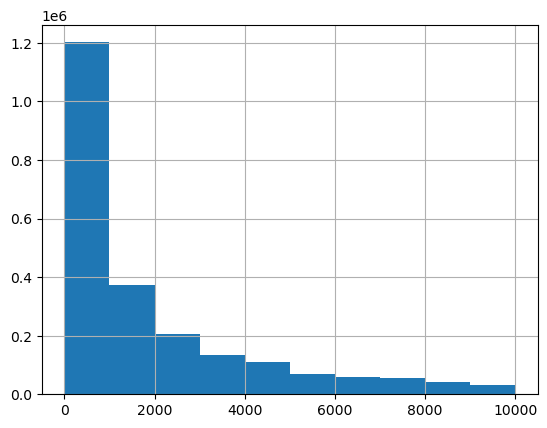

In [114]:
# hist prices between $0.1 and $10,000
df[((df['price'] > 0.1) & (df['price'] < 10000))]['price'].hist()

### High Prices

In [115]:
pd.set_option('display.max_rows', 100)

In [116]:
df.sort_values(by='price', ascending=False).head(100).reset_index()

,index,vin,price,odometer_type,mileage,county,zip,model_year,make,model,vehicle_type,new_used,title_issue_date,purchase_date
0,5324810,5XXGM4A74DG239514,8.118003e+12,0,116413,Sumner,37075,2013,KIA,OPT,AUTO,U,2021-12-10,2021-10-02
1,139903,1B3HB48C77D547130,9.401194e+11,1,0,Williamson,37064,2007,DODG,CXT,AUTO,U,2020-05-11,2020-05-09
2,5300816,1G1PC5SH9B7253911,8.602186e+11,0,163038,Unicoi,37601,2011,CHEV,CZL,AUTO,U,2020-03-25,2020-02-28
3,3732587,3GCUKSEJ8HG144346,8.311830e+11,0,92139,Sumner,37075,2017,CHEV,SLV,TRUCK,U,2020-09-01,2020-07-28
4,6934261,W06VR52R7XR008155,8.311830e+11,1,0,Sumner,37075,1999,CADI,CAT,AUTO,U,2021-03-03,2021-02-01
5,6707548,3C6TR5MT0FG505486,7.911790e+11,0,113,Shelby,38133,2015,RAM,250,TRUCK,U,2020-09-17,2020-08-11
6,6489136,JTEES42A582069565,7.911790e+11,1,0,Shelby,38133,2008,TOYT,HGH,AUTO,U,2019-06-18,2019-06-05
7,9337173,WBXPC934X8WJ06914,7.911790e+11,1,0,Shelby,38118,2008,BMW,X3,AUTO,U,2020-06-08,2020-06-05
8,466116,1D7HA18P47S257562,7.902179e+11,1,0,Shelby,38002,2007,DODG,RAM,TRUCK,U,2021-03-29,2021-03-29
9,3757614,2T1CG22P5YC328627,7.201172e+11,1,0,Rhea,37332,2000,TOYT,CAM,AUTO,U,2020-09-03,2018-12-11


I suspect some counties are adding zeros for decimal

- 1m = $10,000.00
- 10m = $100,000.00

<AxesSubplot:>

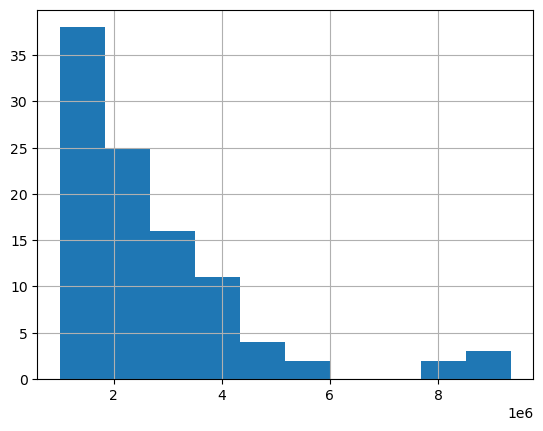

In [117]:
# between $1m and $10m
condition_low = df['price'] > 1000000
condition_high = df['price'] < 10000000
df[condition_low & condition_high]['price'].hist()

In [134]:
# mean prices by county

nums = df.groupby('county')['price'].mean().sort_values(ascending=False)
index = nums.index

for i in range(len(nums)):
    print("{}: ${:0,.2f}".format(index[i],nums[i]))

Sumner: $65,039,780.00
Unicoi: $42,629,816.00
Greene: $21,020,718.00
Rhea: $19,698,620.00
Williamson: $5,504,215.00
Madison: $5,126,476.50
Shelby: $5,018,479.00
Davidson: $313,903.78
Knox: $12,465.07
Fayette: $11,335.27
Dyer: $10,279.17
Tipton: $10,272.22
Henry: $9,804.82
Gibson: $9,804.49
Henderson: $9,434.28
Anderson: $9,425.70
Washington: $9,416.22
Bedford: $9,312.57
Hardin: $9,252.50
Hardeman: $9,195.68
Roane: $8,739.39
Crockett: $8,098.24
Lauderdale: $8,063.53
Cheatham: $7,803.85
Carroll: $7,603.21
McNairy: $7,214.13
Chester: $6,731.81
Wayne: $6,098.51
Houston: $6,032.91
Lake: $6,013.06
Polk: $5,872.87
Bledsoe: $5,687.14
Trousdale: $5,655.52
Dekalb: $5,611.52
Moore: $5,433.33
Humphreys: $5,300.61
Smith: $5,296.35
Macon: $5,201.29
Hamblen: $4,790.07
Meigs: $4,540.94
Johnson: $4,518.95
Claiborne: $4,495.70
Fentress: $4,337.81
Jackson: $4,280.34
Van Buren: $4,279.90
Campbell: $4,214.69
Clay: $4,174.17
Pickett: $3,870.86
Hickman: $3,597.12
Carter: $3,503.78
Loudon: $3,429.89
Lincoln: 

## The Rest

In [42]:
# non-numeric
df.describe(include = ['object','category']).T

,count,unique,top,freq
vin,9831770,7558172,CCZ264F146470,17
odometer_type_code,9831774,5,0,5185393
county_name,9831774,97,State,1086116
zip,9831774,5968,37218,172902
make_code,9831774,8580,FORD,1360587
model_code,9831188,24683,F15,286477
vehicle_type_description,9831774,16,AUTO,6973439
new_used_code,9831774,2,U,7907848
title_issue_date,9830879,5940,2021-03-22,11262
purchase_date,9831774,13427,2018-01-11,61936


In [44]:
# null counts
pd.DataFrame({'count':df.isna().sum()
             ,'percent':(df.isna().sum()/df.shape[0]).round(decimals=2)}
    ).sort_values(by='count', ascending=False)

,count,percent
vehicle_cost,331544,0.03
title_issue_date,895,0.00
model_code,586,0.00
vin,4,0.00
odometer_reading,1,0.00
odometer_type_code,0,0.00
county_name,0,0.00
zip,0,0.00
model_year,0,0.00
make_code,0,0.00


In [ ]:
# 0 or filler counts